<a href="https://colab.research.google.com/github/fmathews11/College_Basketball_Functions/blob/main/Pulling_Gameplan_From_Kenpom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kenpompy
!pip install mechanicalsoup
import mechanicalsoup,pandas as pd,numpy as np, warnings,seaborn as sns, matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from kenpompy.utils import login
warnings.filterwarnings("ignore")

In [41]:
browser = login()
def get_team_gameplan(browser,team):

  #Pull in HTML
  url = 'https://kenpom.com/gameplan.php?team='+str(team)
  browser.open(url)
  raw_source = browser.get_current_page()
  table = raw_source.find_all('table')
  df = pd.read_html(str(table[0]))[0]

  #Let's Clean it up
  df.columns = [i[0] +  "_" +i[1] for i in df.columns.tolist()]
  df = df.drop([df.columns[i] for i in [1,7,12,14,18]],axis = 1)

  #Column name cleaning
  for i in df.columns:
    if "." in i:
      df = df.rename(columns = {i:i[:-2]})
  for i in df.columns:
    if "Unnamed" in i:
      df = df.rename(columns = {i:i.split()[-1]})
  for i in df.columns:
    if "level" in i:
      df = df.rename(columns = {i:i.split("_")[-1]})


  #Remove Extra Junk From the end
  cutoff_value = np.where(df.Date == "Correlations (R x 100)")[0][0]
  df = df.iloc[:cutoff_value,:]

  #Splitting the results column
  result_vals = [i for i in df.Result.tolist()]
  df.Result = [str(i[0]) for i in result_vals]
  df['Score'] = [str(i.split(',')[-1]) for i in result_vals]

  col_names = ['Date',
              'Opponent',
              'Result',
              'Location',
              'Pace',
              'Offense_Eff',
              'Offense_eFG%',
              'Offense_TO%',
              'Offense_OR%',
              'Offense_FTR',
              'Offense_2P%',
              'Offense_3P%',
              'Offense_3PA%',
              'Defense_Eff',
              'Defense_eFG%',
              'Defense_TO%',
              'Defense_OR%',
              'Defense_FTR',
              'Defense_2P%',
              'Defense_2P%',
              'Defense_3P%',
              'Defense_3P%',
              'Defense_3PA%',
              'Score']
  df.columns = col_names
  df.Result = df.Result.map({"W":1,"L":0})

  #Coerce all strings to numeric type for computation
  for i in df.columns:
   try:
     df[i] = pd.to_numeric(df[i])
   except:
     pass

  return df


In [ ]:
df = get_team_gameplan(browser,'Purdue')
df

In [64]:
target_df = df[['Date','Opponent','Offense_Eff','Result']]
#target_df.Defense_Eff = target_df.Defense_Eff.astype(float)
#target_df.rename(columns = {'Offsnsive_Eff':"Raw_Offensive_Efficiency_Against_Purdue"},inplace = True)
target_df['Season_Average'] = 122.8
target_df['Efficiency_Differential'] = target_df.Offense_Eff - target_df.Season_Average
target_df = target_df.sort_values("Efficiency_Differential")
target_df

,Date,Opponent,Offense_Eff,Result,Season_Average,Efficiency_Differential
24,Thu Feb 10,Michigan,93.6,0,122.8,-29.2
17,Thu Jan 20,Indiana,98.1,0,122.8,-24.7
7,Fri Dec 3,Iowa,101.3,1,122.8,-21.5
13,Mon Jan 3,Wisconsin,103.4,0,122.8,-19.4
8,Thu Dec 9,Rutgers,103.7,0,122.8,-19.1
9,Sun Dec 12,N.C. State,109.3,1,122.8,-13.5
16,Mon Jan 17,Illinois,113.4,1,122.8,-9.4
14,Sat Jan 8,Penn St.,119.0,1,122.8,-3.8
3,Sat Nov 20,North Carolina,121.5,1,122.8,-1.3
20,Sun Jan 30,Ohio St.,123.7,1,122.8,0.9


In [79]:
import kenpompy.summary as kp
sum_df = kp.get_efficiency(browser,2022)
sum_df_ = sum_df.copy()
sum_df[sum_df.Team == 'Purdue']

,Team,Conference,Tempo-Adj,Tempo-Adj.Rank,Tempo-Raw,Tempo-Raw.Rank,Avg. Poss Length-Offense,Avg. Poss Length-Offense.Rank,Avg. Poss Length-Defense,Avg. Poss Length-Defense.Rank,Off. Efficiency-Adj,Off. Efficiency-Adj.Rank,Off. Efficiency-Raw,Off. Efficiency-Raw.Rank,Def. Efficiency-Adj,Def. Efficiency-Adj.Rank,Def. Efficiency-Raw,Def. Efficiency-Raw.Rank
237,Purdue,B10,66.5,228,67.0,249,17.7,205,18.1,302,125.3,1,122.8,1,100.3,128,102.0,199


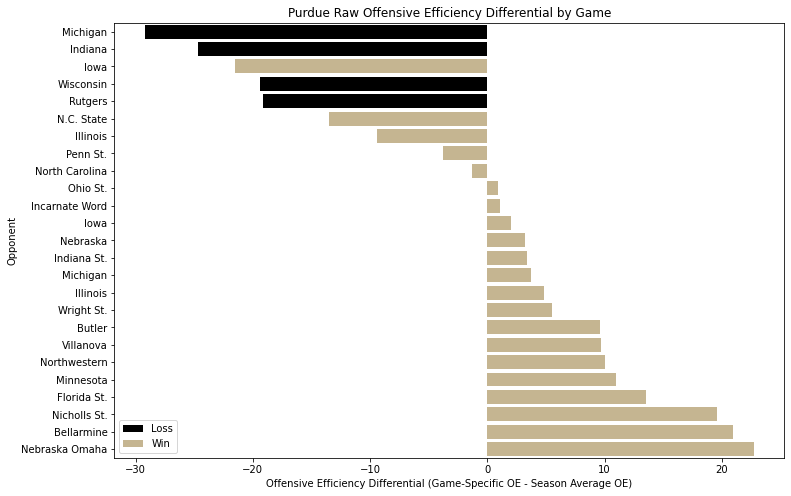

In [68]:
plt.figure(figsize = (12,8))
g = sns.barplot(data = target_df,
            x = "Efficiency_Differential",
            y = 'Date',
            hue = 'Result',
            orient = "h",
            dodge = False,
            ci = None,
            palette = ["#000000","#CEB888"])
plt.legend(labels = ['Loss','Win'])
plt.title("Purdue Raw Offensive Efficiency Differential by Game",size = 12A)
plt.xlabel("Offensive Efficiency Differential (Game-Specific OE - Season Average OE)")
plt.yticks(ticks = [i for i in range(len(target_df))],labels = target_df.Opponent)
plt.ylabel("Opponent")
plt.show();

In [149]:
team_1 = 'Purdue'
team_2 = 'Maryland'

sum_df = sum_df_.copy()
for i in sum_df.columns:
  try:
    sum_df[i] = pd.to_numeric(sum_df[i])
  except:
    pass
sum_df.columns = ['_'.join(i.split()) for i in sum_df.columns.tolist()]
sum_df.columns = [i.replace(".","") for i in sum_df.columns]
sum_df.columns = [i.replace("-","_") for i in sum_df.columns]
off_eff_avg = round(sum_df.Off_Efficiency_Adj.mean(),2)
def_eff_avg = round(sum_df.Def_Efficiency_Adj.mean(),2)

team_1_off_eff = sum_df.loc[sum_df.Team == team_1].Off_Efficiency_Adj.item()
team_1_def_eff = sum_df.loc[sum_df.Team == team_1].Def_Efficiency_Adj.item()
team_2_off_eff = sum_df.loc[sum_df.Team == team_2].Off_Efficiency_Adj.item()
team_2_def_eff = sum_df.loc[sum_df.Team == team_2].Def_Efficiency_Adj.item()
team_1_tempo = sum_df.loc[sum_df.Team == team_1].Tempo_Adj.item()
team_2_tempo = sum_df.loc[sum_df.Team == team_2].Tempo_Adj.item()

team_1_off_pct = (team_1_off_eff/off_eff_avg)-1
team_1_off_pct_adjustment_factor = 1+round(team_1_off_pct + ((team_2_def_eff/def_eff_avg) - 1),2)
team_1_off_adj = round(off_eff_avg * team_1_off_pct_adjustment_factor,2)
print(f"{team_1}'s expected efficiency is {team_1_off_adj}")

team_2_off_pct = (team_2_off_eff/off_eff_avg)-1
team_2_off_pct_adjustment_factor = 1+round(team_2_off_pct + ((team_1_def_eff/def_eff_avg) - 1),2)
team_2_off_adj = round(off_eff_avg * team_2_off_pct_adjustment_factor,2)
print(f"{team_2}'s expected efficiency is {team_2_off_adj}")
print(f"{team_1} averages {round(team_1_tempo)} possessions per game")
print(f"{team_2} averages {round(team_2_tempo)} possessions per game")
print(f"{team_1} is therefore expected to score {round((team_1_tempo)*(team_1_off_adj/100)+3.75)} points")
print(f"{team_2} is therefore expected to score {round((team_2_tempo)*(team_2_off_adj/100))} points")

Purdue's expected efficiency is 122.36
Maryland's expected efficiency is 104.88
Purdue averages 66 possessions per game
Maryland averages 67 possessions per game
Purdue is therefore expected to score 85 points
Maryland is therefore expected to score 70 points


,Team,Conference,Tempo_Adj,Tempo_AdjRank,Tempo_Raw,Tempo_RawRank,Avg_Poss_Length_Offense,Avg_Poss_Length_OffenseRank,Avg_Poss_Length_Defense,Avg_Poss_Length_DefenseRank,Off_Efficiency_Adj,Off_Efficiency_AdjRank,Off_Efficiency_Raw,Off_Efficiency_RawRank,Def_Efficiency_Adj,Def_Efficiency_AdjRank,Def_Efficiency_Raw,Def_Efficiency_RawRank
